# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")
#env = UnityEnvironment(file_name="VisualBanana.app")



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


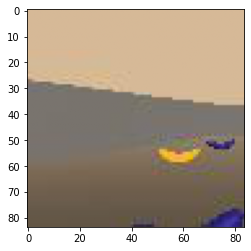

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

In [149]:
import torch
import cv2

from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay

from lib.dqn import dqn
from lib.models import DuelingConvQNetwork, ConvQNetwork

import matplotlib.pyplot as plt
%matplotlib inline

import json

CANNY_LOW = 15
CANNY_HIGH = 300

def create_colors_from_coords(image, coord):
    blue = image[coord[0][0]:coord[0][1],coord[1][0]:coord[1][1],:]
    #blue = hsv[56:62,53:71,:]
    blue = blue
    plt.imshow(blue)
    plt.show()
    #print('blue.shape',blue.shape)
    blue_reshape = blue.reshape(blue.shape[0] * blue.shape[1], blue.shape[2])
    return blue_reshape

def save_colors(colors, name):
    d = [c.tolist() for c in colors]
    with open(f'{name}.json', 'w') as fp:
        json.dump(d, fp)

def load_colors(name):
    with open(f'{name}.json') as fp:
        data = json.load(fp)
    return [np.array(c) for c in data]

def create_color_boundaries(colors):
    boundaries = [(c, c) for c in colors]
    return boundaries

def draw_bounding_rectangles(image, color, canny_low=CANNY_LOW, canny_high=CANNY_HIGH):

    edges = cv2.Canny(image.astype('uint8'), canny_low, canny_high)
    edges = cv2.dilate(edges, None)
    #print('show edges')
    #plt.imshow(edges)
    #plt.show()

    contours,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print('number of contours', len(contours))

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    # if no contours then set single area to 0
    rectAreas = [0]*(max(1,len(contours)))
    for i, c in enumerate(contours):
        #print(c)
        contours_poly[i] = cv2.approxPolyDP(c, 1, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        print('boundRect', boundRect[i])
        rectAreas[i] = abs(int(boundRect[i][2] * boundRect[i][3]))

    drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)

    for i in range(len(contours)):
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, -1)
    return drawing, rectAreas

def mask_by_color(image, boundaries):
    accumMask = np.zeros(image.shape[:2], dtype="uint8")
    #print('len boundaries', len(boundaries))
    for (lower, upper) in boundaries:
        # find the colors within the specified boundaries
        mask = cv2.inRange(image, lower, upper)
        #print('sum mask', np.sum(mask))
        # merge the mask into the accumulated masks    
        accumMask = cv2.bitwise_or(accumMask, mask)

    return cv2.bitwise_or(image, image, mask=accumMask) 

def rectangles_color(image, 
                     boundaries, 
                     rectangle_color,
                     canny_low=CANNY_LOW,
                     canny_high=CANNY_HIGH):
    masked = mask_by_color(image, boundaries)
    return draw_bounding_rectangles(masked, 
                                    rectangle_color,
                                    canny_low=canny_low,
                                    canny_high=canny_high)


def create_model(state_size, action_size, seed):
    # return ConvQNetwork(state_size, action_size, seed, fc_units=[512])
    return ConvQNetwork(state_size, action_size, seed, fc_units=[64, 64])
    # return DuelingConvQNetwork(state_size, action_size, seed)


def create_mask_extract_bananas(img):
    accumMask = np.zeros(img.shape[:2], dtype="uint8")

    # define the list of color boundaries
    boundaries = [
        ([30, 10, 60], [80, 100, 140]),
        ([240, 175, 0], [255, 255, 120])
    ]

    # loop over the boundaries
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype="uint8")/255
        upper = np.array(upper, dtype="uint8")/255

        # find the colors within the specified boundaries
        mask = cv2.inRange(img, lower, upper)

        # merge the mask into the accumulated masks
        accumMask = cv2.bitwise_or(accumMask, mask)
    return accumMask

def create_mask_exclude_background(img):
    accumMask = np.zeros(img.shape[:2], dtype="uint8")

    # define the list of color boundaries
    # boundaries = [
    #     ([170, 150, 125], [230, 200, 180]),
    #     ([110, 90, 60], [160, 160, 160]),
    #     ([40, 30, 50], [140, 120, 130])
    # ]
    boundaries = [
    ([95,    70,    27],[105,82,50]),
    ([100,83,70],[109,109,117]),
    ([205,197,84],[205,197,84]),
    ([199, 192, 184], [199, 192, 184]),
    ([166, 150, 125], [230, 200, 180]),
    ([110, 90, 60], [160, 160, 160]),
    ([210, 201, 171], [241, 246, 242]),
    ([180,163,140],[236,228,210]),
    ([47,55,45], [98,98, 110])
   # ([40, 30, 50], [140, 120, 130])
    ]

    # loop over the boundaries
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype="uint8")/255
        upper = np.array(upper, dtype="uint8")/255

        # find the colors within the specified boundaries
        mask = cv2.inRange(img, lower, upper)

        # merge the mask into the accumulated masks
        accumMask = cv2.bitwise_or(accumMask, mask)
    return accumMask

def process_image_old(img):
    #imageMask = create_mask_extract_bananas(img)
    imageMask = create_mask_exclude_background(img)
    
    res = cv2.bitwise_or(img, img, mask=imageMask) 
    #-- Contains pixels having the gray color--
    #res = cv2.bitwise_not(img, img, mask=imageMask)  
    
    res[res < 0] = 0 
    return res

def process_image(img, 
                  colour1_boundaries=([100,150,0], [140,255,255]), 
                  colour2_boundaries=([20, 100, 100], [30, 255, 255]),
                  canny_low=CANNY_LOW,
                  canny_high=CANNY_HIGH):
    img = (img * 255).astype('uint8')
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  #  plt.imshow(hsv)
  #  plt.show()
  #  print('-------- show portion -----------')
  #  plt.imshow(hsv[52:56,42:48])
  #  plt.show()
  #  print(hsv[52:56,42:48])


    #blue_color = (130, 255,  255)
    blue_color = (25, 100,  100)

    blue_boundaries = [(np.array(colour1_boundaries[0],np.uint8), 
                        np.array(colour1_boundaries[1],np.uint8))]
    #print('---------- blue Rectangles ------------ ')
    blue_rectangles, blueRectAreas = rectangles_color(hsv, 
                                                      blue_boundaries, 
                                                      blue_color,
                                                      canny_low=canny_low,
                                                      canny_high=canny_high)
    #print('blueRectAreas', blueRectAreas)

    yellow_color = (130, 255,  255)
    #yellow_color = (25, 100,  100)

    #yellow_boundaries = [(np.array([20, 100, 100]), np.array([30, 255, 255]))]
    yellow_boundaries = [(np.array(colour2_boundaries[0],np.uint8), 
                        np.array(colour2_boundaries[1],np.uint8))]

    #print('---------- yellow Rectangles ------------ ')
    yellow_rectangles, yellowRectAreas = rectangles_color(hsv, yellow_boundaries, yellow_color)
    #print('yellowRectAreas',yellowRectAreas)

    combined = cv2.bitwise_or(yellow_rectangles, blue_rectangles) 
    return combined/255, np.max(yellowRectAreas), np.max(blueRectAreas) 

def get_state(env_info):
    state = env_info.visual_observations[0] 
    # remove axis of length 1
    #s'tate = np.s'queeze(state)
    #state = np.transpose(state, (2, 0, 1))
    #print('get_state shape', state.shape)
    state[0], maxYellowArea, maxBlueArea = process_image(state[0])
    #print('get_state shape', state.shape)
    #print('processed state', state)
    #print('maxYellowArea', maxYellowArea, 'maxBlueArea', maxBlueArea)
    return state




In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size


In [208]:
action = 0 # forward
action = 3 # right
action = 1 # backward
action = 2 # left

env_info = env.step(action)[brain_name]        # send the action to the environment


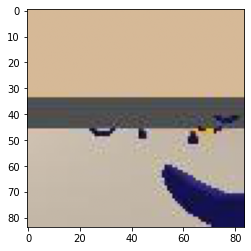

---------- blue Rectangles ------------ 
boundRect (51, 60, 33, 24)
boundRect (72, 40, 5, 8)
blueRectAreas [792, 40]
---------- yellow Rectangles ------------ 
yellowRectAreas [0]
maxYellowArea 0 maxBlueArea 792
yellow reward 0.0 blue reward -0.11224489795918367


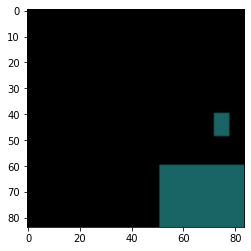

In [209]:

state = env_info.visual_observations[0] 
#blue_boundaries=([100,150,0], [140,255,255])
blue_boundaries=([120,145,50], [130,255,130])

img = state[0]
plt.imshow(img)
plt.show()

#yellow_boundaries=([20, 100, 100], [30, 117, 117])
yellow_boundaries=([18, 176, 235], [22, 227, 255])

processed_image, maxYellowArea, maxBlueArea = process_image(img,
                                                 colour1_boundaries=blue_boundaries,
                                                 colour2_boundaries=yellow_boundaries)
print('maxYellowArea', maxYellowArea, 'maxBlueArea', maxBlueArea)
max_area = 84 * 84
print('yellow reward', maxYellowArea/max_area, 'blue reward', -maxBlueArea/max_area)
plt.imshow(processed_image)
plt.show()



In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = get_state(env_info)
# print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

agent = AgentPrioritizedExperienceReplay(state_size=state_size,
                                         action_size=action_size,
                                         seed=0,
                                         train_mode=True,
                                         #batch_size=32,
                                         create_model=create_model
                               )


agent_name = 'pixel_conv'

# agent.load_model(agent_name)
n_episodes = 500


scores = dqn(env, 
             brain_name, 
             agent,
             n_episodes=n_episodes,
             #eps_end=0.1, 
             checkpoint=13,
             agent_name=agent_name,
             get_state=get_state,
             batched_state=True)

agent.save_model(agent_name)


pixel_conv


In [6]:
agent.save_model(agent_name)
